In [1]:
import os
import sys

current_dir = os.path.dirname(os.path.abspath('clustering_analysis.ipynb'))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from kalman_filter_bank.kalman_filter import SinusoidalKalmanFilter
from kalman_filter_bank.filter_bank import SinusoidalCMMEAFilterBank, run_filter_bank

In [3]:
def read_data():
    # load in the price data
    data_df = pd.read_csv('../data/btc_1m.csv')
    # compute the rate of return -- makes the price easier to track
    data_df['rate'] = (data_df['Open'].values - data_df['Open'].values[0]) / data_df['Open'].values[0]
    return data_df

df = read_data()
df.head()

,Date,Time,EpochTime,Open,High,Low,Close,Volume,rate
0,2025-07-31,02:15:00Z,1753928100,118230.01,118230.01,118200.01,118230.01,3.583388,0.000000
1,2025-07-31,02:16:00Z,1753928160,118230.01,118238.45,118215.00,118219.28,1.053575,0.000000
2,2025-07-31,02:17:00Z,1753928220,118219.32,118269.64,118215.00,118262.50,1.593586,-0.000090
3,2025-07-31,02:18:00Z,1753928280,118262.50,118267.98,118262.50,118267.98,0.337689,0.000275
4,2025-07-31,02:19:00Z,1753928340,118267.98,118267.98,118238.47,118242.06,0.522006,0.000321


In [4]:
dw = 0.01
omega_arr = np.arange(dw, 5 + dw, dw)

sigma_xi = [1e1] * len(omega_arr)   # model confidence
rho = [5e-3] * len(omega_arr)  # measurement noise confidence
dt = len(df.Date.unique()) / len(df.rate.values)
measurements = df.rate.values.reshape(-1, 1)

cmmea = SinusoidalCMMEAFilterBank(
    dim_x=2,
    dim_z=1,
    omegas=omega_arr,
    dt=dt,
    sigma_xi=sigma_xi,
    rho=rho
)

cmmea_dict = run_filter_bank(cmmea, measurements)

Running the Filter Bank for 14400 steps


  0%|          | 0/14400 [00:00<?, ?it/s]

100%|██████████| 14400/14400 [03:06<00:00, 77.07it/s]


In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

os.makedirs("cmmea_clusters", exist_ok=True)

In [12]:
amps  = np.asarray(cmmea_dict['amp'])
weights = np.asarray(cmmea_dict['w'])
omegas = np.asarray(cmmea.omegas).reshape(-1)

amp_mean = np.nanmean(amps, axis=0)
weight_mean = np.nanmean(weights, axis=0)

# Assembling the feature tensor: [omega, mean_amp, mean_weight]
features = np.column_stack([omegas, amp_mean, weight_mean])
feat_cols = ["omega", "amp_mean", "weight_mean"]
feat_df = pd.DataFrame(features, columns=feat_cols)

feat_path = os.path.join("cmmea_clusters", "cmmea_feature_tensor.csv")
feat_df.to_csv(feat_path, index=False)
feat_df.head()

,omega,amp_mean,weight_mean
0,0.01,1.807873,0.002671
1,0.02,0.904971,0.002671
2,0.03,0.604343,0.002671
3,0.04,0.454249,0.002672
4,0.05,0.364350,0.002672


In [13]:
X = feat_df[feat_cols].values.copy()

scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[:, 1:3] = scaler.fit_transform(X[:, 1:3])

In [15]:
def inverse_centers_amp_weight(centers_scaled, scaler):
    # Inverse-transforms only the amp/weight columns of KMeans centers
    centers = centers_scaled.copy()
    centers[:, 1:3] = scaler.inverse_transform(centers[:, 1:3])
    return centers

all_labels = {}

for K in (3, 4, 5):
    km = KMeans(n_clusters=K, n_init=50, random_state=42)
    labels = km.fit_predict(X_scaled)
    all_labels[K] = labels

    # Centers back in original units for amp & weight (freq was never scaled)
    centers_orig = inverse_centers_amp_weight(km.cluster_centers_, scaler)
    cent_df = pd.DataFrame(centers_orig, columns=feat_cols)
    cent_df.insert(0, "centroid_id", np.arange(K))

    # Saving centroids & frequency-only centroid list
    cent_path = os.path.join("cmmea_clusters", f"centroids_k{K}.csv")
    cent_df.to_csv(cent_path, index=False)

    freq_centroids = np.sort(cent_df["omega"].values)

    print(f"\nK={K} centroid frequencies (ω):", np.round(freq_centroids, 6))


K=3 centroid frequencies (ω): [0.02  1.345 3.83 ]

K=4 centroid frequencies (ω): [0.02 0.66 2.04 3.9 ]

K=5 centroid frequencies (ω): [0.02  0.565 1.805 3.025 4.27 ]


In [16]:
assign_df = feat_df.copy()
for K, labels in all_labels.items():
    assign_df[f"cluster_k{K}"] = labels

assign_path = os.path.join("cmmea_clusters", "assignments_allK.csv")
assign_df.to_csv(assign_path, index=False)
assign_df.head()

,omega,amp_mean,weight_mean,cluster_k3,cluster_k4,cluster_k5
0,0.01,1.807873,0.002671,2,2,2
1,0.02,0.904971,0.002671,2,2,2
2,0.03,0.604343,0.002671,2,2,2
3,0.04,0.454249,0.002672,0,3,4
4,0.05,0.364350,0.002672,0,3,4


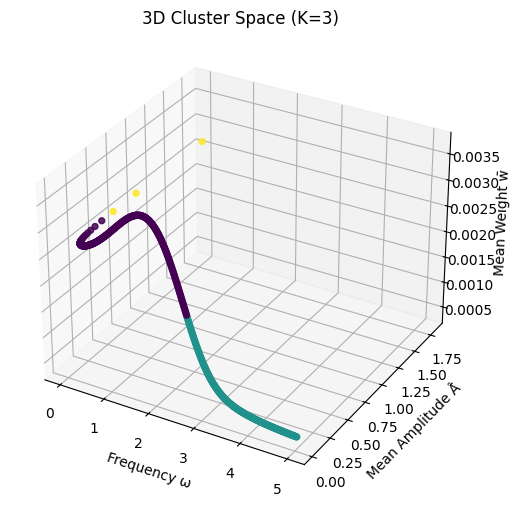

   centroid_id  omega  amp_mean  weight_mean
0            0  1.345  0.045930     0.003115
1            1  3.830  0.026379     0.000748
2            2  0.020  1.105729     0.002671


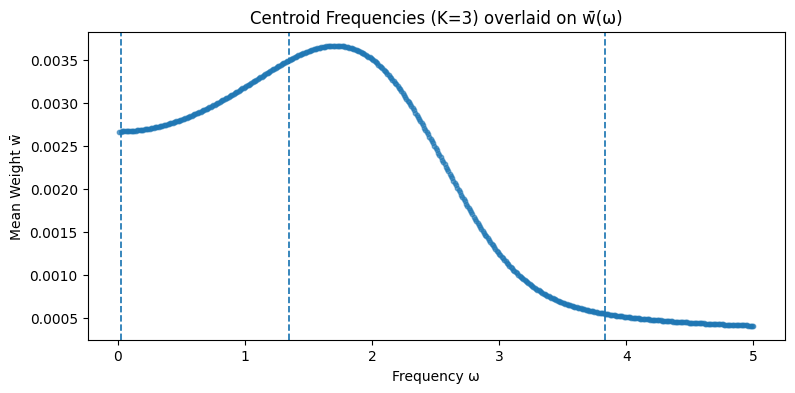

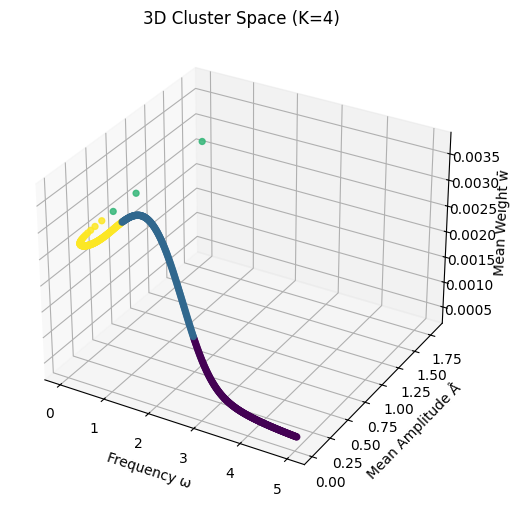

   centroid_id  omega  amp_mean  weight_mean
0            0   3.90  0.026326     0.000677
1            1   2.04  0.028631     0.003126
2            2   0.02  1.105729     0.002671
3            3   0.66  0.064733     0.002963


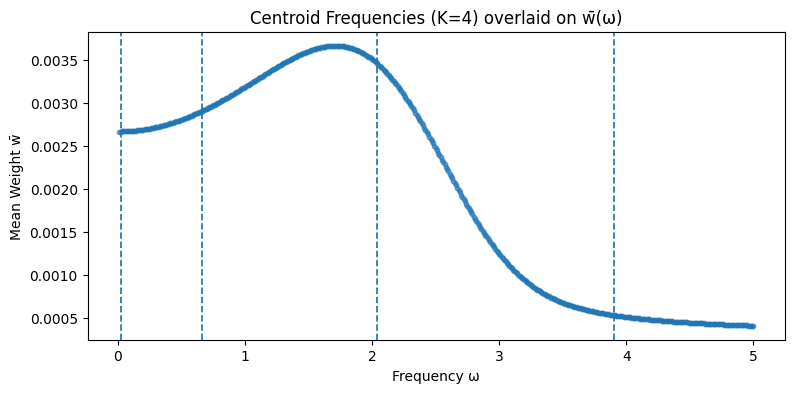

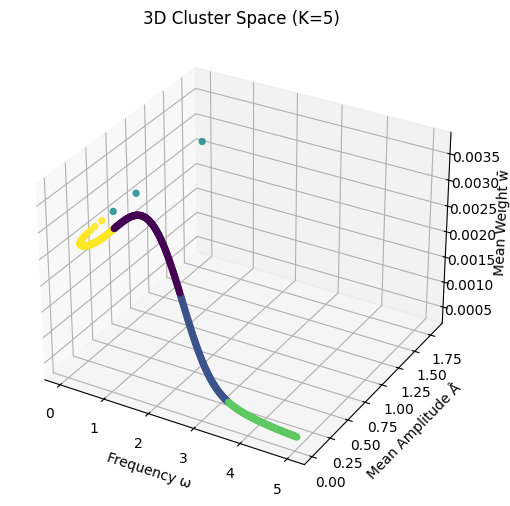

   centroid_id  omega  amp_mean  weight_mean
0            0  1.805  0.029368     0.003368
1            1  3.025  0.026939     0.001327
2            2  0.020  1.105729     0.002671
3            3  4.270  0.026087     0.000489
4            4  0.565  0.070567     0.002891


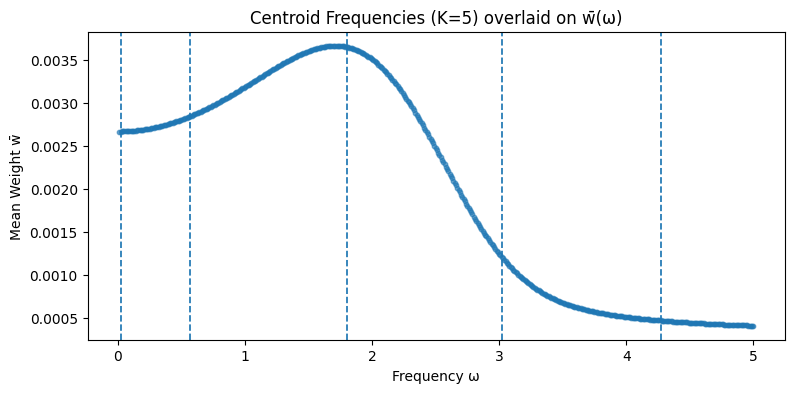

In [18]:
def plot_3d(feat_df, labels, K):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(
        feat_df["omega"].values,
        feat_df["amp_mean"].values,
        feat_df["weight_mean"].values,
        c=labels, s=18, alpha=0.85
    )
    ax.set_xlabel("Frequency ω")
    ax.set_ylabel("Mean Amplitude Â̄")
    ax.set_zlabel("Mean Weight w̄")
    ax.set_title(f"3D Cluster Space (K={K})")
    plt.show()

def plot_freq_axis(feat_df, cent_df, K):
    print(cent_df.head())
    fig = plt.figure(figsize=(9,4))
    # Scatter of w̄ vs ω
    plt.scatter(feat_df["omega"].values, feat_df["weight_mean"].values, s=10, alpha=0.6)
    for w0 in np.sort(cent_df["omega"].values):
        plt.axvline(w0, linestyle="--", linewidth=1.25)
    plt.xlabel("Frequency ω")
    plt.ylabel("Mean Weight w̄")
    plt.title(f"Centroid Frequencies (K={K}) overlaid on w̄(ω)")
    plt.show()

for K, labels in all_labels.items():
    plot_3d(feat_df, labels, K)
    cent_df = pd.read_csv(os.path.join("cmmea_clusters", f"centroids_k{K}.csv"))
    plot_freq_axis(feat_df, cent_df, K)